In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

## Load SPS BPM data
Data from first turn for 25 ns beam (closed orbit subtracted)

In [3]:
# Load data for injection trajectory
bpm_data = xt.json.load('bpm_data.json')

# Use Xsuite table for easy access and visualization
bpm_meas = xt.Table(data={
    'name': np.array(bpm_data['bpm_name']),
    'x_meas': np.array(bpm_data['x_position']),
})

In [4]:
# Look at data for one BPM
bpm_meas['x_meas', 'bph.62608']

0.0028319

Text(0.5, 0, 'Monitor number')

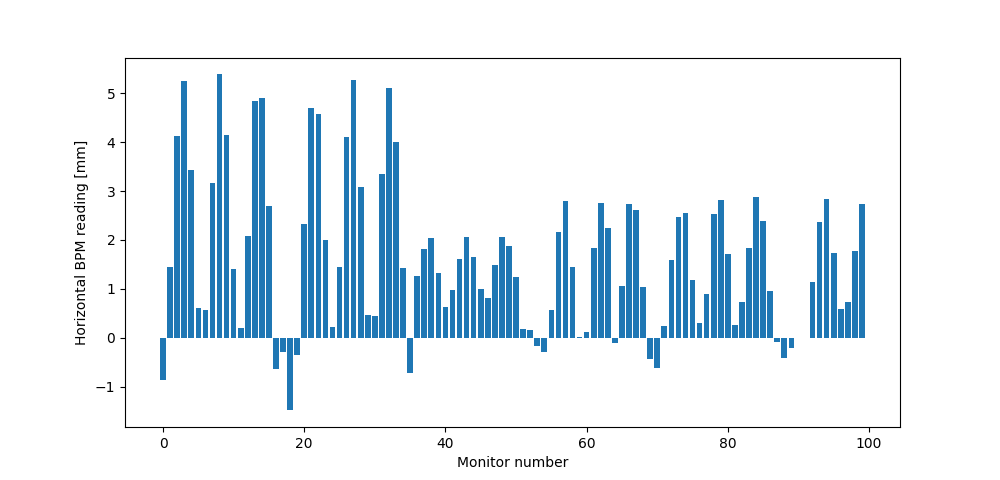

In [5]:
# Plot data (excursions observed to be larger in the first two sectors)
plt.figure(figsize=(10, 4.8))
plt.bar(height=bpm_meas.x_meas*1e3, x=range(len(bpm_meas)))
plt.ylabel('Horizontal BPM reading [mm]')
plt.xlabel('Monitor number')

### Load Xsuite model of the SPS

In [6]:
# Load lattice
env = xt.load_madx_lattice('sps.seq')
sps = env['sps']

# Load optics
sps.vars.load_madx('q20_optics.str')

# Set reference patricle
sps.particle_ref = xt.Particles(mass0=xt.PROTON_MASS_EV, q0=1, p0c=26e9(

In [7]:
# Setup RF (200 MHz)
sps.set('actcse.31632', voltage=4.5e6, lag=180., frequency=200e6)
sps.set('acl.31735', voltage=0.45e6, lag=0., frequency=800e6)

In [8]:
# Twiss to check the model
tw = sps.twiss()
print(f'qx={tw.qx:.4f}, qy={tw.qy:.4f}, qs={tw.qs:.4f}')

ValueError: Either `particle_ref` or `co_guess` must be provided

### Compute first turn trajectory

In [ ]:
# Use variables to define the initial conditions
sps['x_inj'] = 1e-3
sps['px_inj'] = 0.
sps['delta_inj'] = 2e-4
sps['zeta_inj'] = 0.

tw_turn_1 = sps.twiss(
    betx=1, bety=1,
    x=sps['x_inj'], px=sps['px_inj'],
    delta=sps['delta_inj'], zeta=sps['zeta_inj'])

tw_turn_1.plot('x')

### Can we find initial conditions for which the model reproduces the measured trajectory?

We can use the Xsuite optimizer to seach for such conditions

In [ ]:
# Define an action computing the first tune trajectory
@xt.Action
def tw_1st_turn():
    return sps.twiss(
        betx=1, bety=1,
        x=sps['x_inj'], px=sps['px_inj'],
        delta=sps['delta_inj'], zeta=sps['zeta_inj'])

In [ ]:
# The action can be used to define an optimization target, for example:
target_bph_63608 = tw_1st_turn.target('x', 1e-3, at='bph.63608')

In [ ]:
# We can use a python for loop to create targets aiming at maching the measurements at all BPMs
targets = []
for nn in bpm_meas['name']:
    targets.append(tw_1st_turn.target('x', bpm_meas['x_meas', nn], at=nn))

In [ ]:
# Build an optimizer object
opt = sps.match(
    solve=False,
    vary=[
        xt.Vary('x_inj', step=1e-4),
        xt.Vary('px_inj', step=1e-6),
        xt.Vary('delta_inj', step=1e-5),
        xt.Vary('zeta_inj', step=1e-3),
    ],
    targets=targets
)

In [ ]:
# Search solution
opt.step(10)         # Jacobian solver
opt.run_simplex(100) # Nelder-Mead solver

In [ ]:
# Inspect solution
opt.vary_status()

### Compare model against measurements

In [ ]:
tw_turn_1_after_optim = tw_1st_turn()

In [ ]:
tw_turn_1_opt_at_bpms = tw_turn_1_after_optim.rows[bpm_meas.name]

In [ ]:
plt.figure(figsize=(10, 4.8))
plt.plot(tw_turn_1_opt_at_bpms.s, tw_turn_1_opt_at_bpms.x * 1e3, '.-', label='Xsuite')
plt.plot(tw_turn_1_opt_at_bpms.s, bpm_meas['x_meas'] * 1e3, '.-', label='Measurement')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('Horizontal position at BPMs [mm]')
plt.grid(True, alpha=0.4)